# 2019 Trendmicro CTF: IOT 100 

In [1]:
! cat prompt.txt

Category: Iot
Points: 100
Wiretap

You have obtained a part of documentation for a "top secret" flag generator device. The documentation includes a part of device firmware source code and a log from a logical analyzer. We suppose the log captured the communication between the microcontroller and the OLED display module

Can you retrieve the flag using the information provided?

Download the file
Extract the downloaded file by using the following password.
Optional: Check integrity of 7z file by comparing file SHA256 checksum.
Command to check SHA256 checksum:
Linux: sha256sum filename.7z
Windows: certUtil -hashfile filename.7z SHA256


> Password: FTIyFedHUVvwzegGPCi6
> SHA256 Checksum: 92cea09299760ec4ad563850e36daaf0f0dabdcb8e2707ef655f2fbbee684eb5
            

In [15]:
! 7z x files13.7z -pFTIyFedHUVvwzegGPCi6 -y > /dev/null
! ls

CTF_oled_qr_code.ino      files13.7z                solution.ipynb
export_i2c_flag_final.csv prompt.txt


# Reading the code

Here is the code that was used to generate the logs. It's pretty simple, it generates a QR code that includes the flag, and then draws this in a display.

## Entire Code

In [18]:
!cat CTF_oled_qr_code.ino

## Display of QR 

This is the most important bits of the code. To understand how this relates to the log file, you may want to read a [bit of i2c](http://www.circuitbasics.com/basics-of-the-i2c-communication-protocol/).

And it definitely helps to look for `SSD1306Wire.h` which can be found in [this repo](https://github.com/ThingPulse/esp8266-oled-ssd1306/blob/master/src/SSD1306Wire.h)

```C
SSD1306Wire  display(0x3c, D3, D5);
display.init();
display.setColor(WHITE);

...
    
for (uint8_t y = 0; y < qrcode.size; y++) {
        // Each horizontal module
        for (uint8_t x = 0; x < qrcode.size; x++) {
           if(qrcode_getModule(&qrcode, x, y)){
            display.setPixel(x, y);

           }
        }
 }

display.display();
```


# Reading the log file

In [21]:
import pandas as pd

df = pd.read_csv('export_i2c_flag_final.csv')

In [26]:
df.head()

,Buffer No.,Packet,Start Time (s),End Time (s),Address Bits,Address,Address + R/W,R/W,Address ACK,Data,Data ACK
0,1,19152,0.071099,0.071252,7,3C,78,Write,0,80 AE,0 0
1,1,19153,0.071279,0.071366,7,3C,78,Write,0,80 D5,0 0
2,1,19154,0.071372,0.071472,7,3C,78,Write,0,80 F0,0 0
3,1,19155,0.071479,0.071566,7,3C,78,Write,0,80 A8,0 0
4,1,19156,0.071576,0.071664,7,3C,78,Write,0,80 3F,0 0


To make sense of this log, we only really have to look at at the `Data` column. And the pattern `80 XX` are actually commands sent by the library to the display. This can be seen in [send_command function](https://github.com/ThingPulse/esp8266-oled-ssd1306/blob/master/src/SSD1306Wire.h#L168)

```C
    inline void sendCommand(uint8_t command) __attribute__((always_inline)){
      initI2cIfNeccesary();
      Wire.beginTransmission(_address);
      Wire.write(0x80);
      Wire.write(command);
      Wire.endTransmission();
    }
```

And these set of first commands are probably from the `init` function. What we really want to concentrate on is what is sent when `display.display()` is called because later we will see that `display.setPixel(x, y)` just stores the pixels in a buffer. We see that [these lines](https://github.com/ThingPulse/esp8266-oled-ssd1306/blob/master/src/SSD1306Wire.h#L103-L128) correspond to the last 14 lines of the log file

```C
        sendCommand(COLUMNADDR);
        sendCommand(x_offset + minBoundX);
        sendCommand(x_offset + maxBoundX);

        sendCommand(PAGEADDR);
        sendCommand(minBoundY);
        sendCommand(maxBoundY);

        byte k = 0;
        for (y = minBoundY; y <= maxBoundY; y++) {
          for (x = minBoundX; x <= maxBoundX; x++) {
            if (k == 0) {
              Wire.beginTransmission(_address);
              Wire.write(0x40);
            }

            Wire.write(buffer[x + y * this->width()]);
            k++;
            if (k == 16)  {
              Wire.endTransmission();
              k = 0;
            }
          }
          yield();
        }
```

In [33]:
df.tail(14)

,Buffer No.,Packet,Start Time (s),End Time (s),Address Bits,Address,Address + R/W,R/W,Address ACK,Data,Data ACK
96,1,19248,0.154363,0.154477,7,3C,78,Write,0,80 21,0 0
97,1,19249,0.154483,0.154570,7,3C,78,Write,0,80 00,0 0
98,1,19250,0.154576,0.154664,7,3C,78,Write,0,80 1C,0 0
99,1,19251,0.154670,0.154757,7,3C,78,Write,0,80 22,0 0
100,1,19252,0.154764,0.154851,7,3C,78,Write,0,80 00,0 0
101,1,19253,0.154861,0.154948,7,3C,78,Write,0,80 03,0 0
102,1,19254,0.154984,0.155494,7,3C,78,Write,0,40 7F 41 5D 5D 5D 41 7F 00 F3 12 DE B5 C7 12 D...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
103,1,19255,0.155525,0.156034,7,3C,78,Write,0,40 C7 12 DE B5 C7 00 7F 41 5D 5D 5D 41 7F A7 3...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
104,1,19256,0.156059,0.156568,7,3C,78,Write,0,40 5C 6E 2D 55 A4 8D FB 43 94 F0 5B C3 94 F0 5...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
105,1,19257,0.156598,0.157107,7,3C,78,Write,0,40 E4 A9 73 3D C3 41 FE 14 9B 5D D4 56 45 42 4...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


We see that after the `40`, `Wire.write(buffer[x + y * this->width()]);` just prints out all the contents of the buffer. 

To understand what buffer has we look at the [setPixel function](https://github.com/ThingPulse/esp8266-oled-ssd1306/blob/42d9d63a8c3cc6f99af8162af2eb754f56e33b11/src/OLEDDisplay.cpp#L126-L134).

```C
void OLEDDisplay::setPixel(int16_t x, int16_t y) {
  if (x >= 0 && x < this->width() && y >= 0 && y < this->height()) {
    switch (color) {
      case WHITE:   buffer[x + (y >> 3) * this->width()] |=  (1 << (y & 7)); break;
        ...
    }
  }
}
```

We see that each cell in the buffer __represents 8 pixels__ for each bit in the buffer. 

In [25]:
import numpy as np

We extract the bytes one by one ignoring the first bytes, `40` 

In [50]:
width = 29
data = []
for e in df['Data'][102:110]:
    data.extend(e.split()[1:])
data = [int(e, 16) for e in data]


Filling up the grid for each on bit in the buffer

In [77]:
#       case WHITE:   buffer[x + (y >> 3) * this->width()] |=  (1 << (y & 7)); break;
grid = np.full((width, width), 255)
for idx, v in enumerate(data):
    x = idx % width
    y = (idx // width) << 3
    
    for i in range(8):
        if (v & (1<<i)) > 0:
            grid[x,y+i] = 0

# Display the image

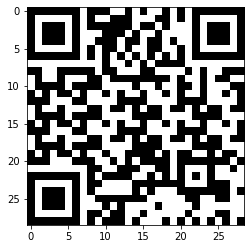

In [80]:
import matplotlib.pyplot as plt
plt.imshow(grid, cmap="gray")
plt.show()